In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import tensorflow as tf


import warnings         # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
%matplotlib inline

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
from tensorflow.compat.v1.keras.callbacks import LearningRateScheduler # колбэк для корректировки скорости обучения
from tensorflow.compat.v1.keras.callbacks import Callback
from tensorflow.compat.v1.keras.models  import Sequential   # Для сборки модели
import tensorflow.compat.v1.keras.layers as L               # Разные слои
import tensorflow.compat.v1.keras.optimizers as opt         # Оптимизаторы
# Для преобразования y в категориальный формат 
from tensorflow.compat.v1.keras.utils import to_categorical  
from tensorflow.compat.v1.keras import backend as K
from tensorflow.compat.v1.keras.callbacks import *

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
X = pd.read_csv('X_cat.csv', sep = '\t', index_col=0)
target = pd.read_csv('y_cat.csv', sep = '\t', index_col=0, header=-1, names=['status'])

print(X.shape)
X.head()

(26729, 37)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,1,0,0,0,0,0,0,1,0,0


In [9]:
target = target.get_values()
target[target == 'Died'] = 'Euthanasia'

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)
y

array([2, 1, 0, ..., 0, 3, 3])

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(21383, 37)
(5346, 37)


In [12]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [13]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [14]:
batch_size = 1000
epochs = 500
learning_rate = 0.001

def fn_model() : 
    model = Sequential()
    
    model.add(L.Dense(25, input_dim = X_train.shape[1], kernel_initializer='random_normal'))
    model.add(L.Activation('sigmoid'))
    
    model.add(L.Dense(25, kernel_initializer='random_normal'))
    model.add(L.Dropout(0.2))
    model.add(L.Activation('sigmoid'))
    
    # На выходе мы должны получить вероятности того, что объект относится к разным классам 
    # Сделать такое преобразование позволяет softmax как функция активации
    # На выход будет идти 4 вероятности по числу классов
    model.add(L.Dense(4, activation='softmax', kernel_initializer = 'random_normal'))
    return model

In [15]:
def plot_history(histories, key='loss', start=0):
    plt.figure(figsize=(16,10))

    for name, history in histories:
        val = plt.plot(history.epoch[start:], history.history['val_'+key][start:],
                       #'--', 
                       label=name.title()+' Val')
            #plt.plot(history.epoch[start:], history.history[key][start:], color=val[0].get_color(),
            #     label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([start, max(history.epoch)])
    pass

In [16]:

class CyclicLR(Callback):
    
    def __init__(self, base_lr=0.001, max_lr=0.1, step_size=100.):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
    
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))

    def on_train_begin(self, logs={}):
        logs = logs or {}
        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())
        
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        

In [17]:
model = fn_model()
sgd = opt.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
lrate = CyclicLR()
callbacks_list = [lrate]

history = model.fit(X_train, y_train, 
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_test, y_test),
                      verbose=0,
                      callbacks=callbacks_list,
                     )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


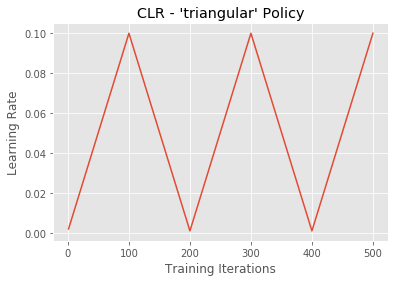

In [18]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(lrate.history['iterations'], lrate.history['lr'])

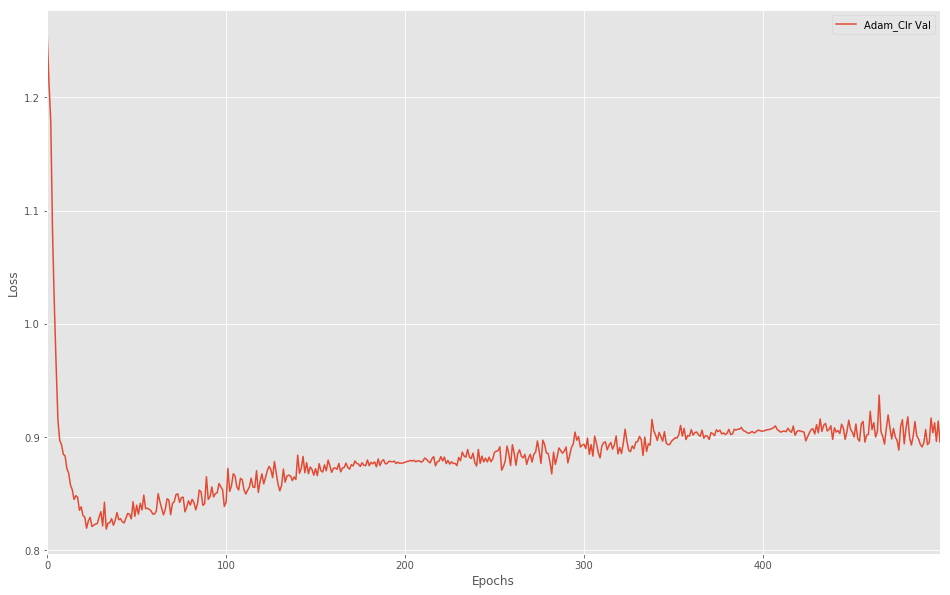

In [20]:
plot_history([
              ('ADAM_CLR', history)
             ],
             start=0)